# Using U-Net Architecture for Fluid Simulation

## Installing Dependencies

In [3]:
%pip install torch --quiet
%pip install torchvision --quiet
%pip install phiflow --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import torch
import torch.nn as nn

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        avg_c = (in_c + out_c) // 2
        
        self.conv1 = nn.Conv2d(in_c, avg_c, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(avg_c)
        
        self.conv2 = nn.Conv2d(avg_c, out_c, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(out_c)
        
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [3]:
class DownSamp(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)
        
        
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        
        return x, p

In [4]:
class UpSamp(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_c, out_c, 2, 2)
        self.conv = ConvBlock(out_c+out_c, out_c)
        
        
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        
        return x

In [5]:
class UNet(nn.Module):
    def __init__(self, in_c, out_c, f_size=16):
        super().__init__()
        
        # Downsampling
        self.down1 = DownSamp(in_c, f_size)
        self.down2 = DownSamp(f_size, f_size*2)
        self.down3 = DownSamp(f_size*2, f_size*4)
        self.down4 = DownSamp(f_size*4, f_size*8)
        
        # Bottleneck
        self.b = ConvBlock(f_size * 8, f_size * 16)
        
        # Upsampling
        self.up1 = UpSamp(f_size * 16, f_size*8)
        self.up2 = UpSamp(f_size * 8, f_size*4)
        self.up3 = UpSamp(f_size * 4, f_size*2)
        self.up4 = UpSamp(f_size * 2, f_size)
        
        # Output
        self.output = nn.Conv2d(f_size, out_c, 1, padding='same')
        
    def forward(self, x):
        # Downsampling
        d1, p1 = self.down1(x)
        d2, p2 = self.down2(p1)
        d3, p3 = self.down3(p2)
        d4, p4 = self.down4(p3)
        
        # Bottleneck
        b = self.b(p4)
        
        # Upsampling
        u1 = self.up1(b, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        
        # Output
        output = self.output(u4)
        
        return output

## Pretraining model

In [6]:
def train_random_epoch(size=32, num_batches=1, batch_size=1):
    last_loss = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i in range(num_batches):
        # Every data instance is an input + label pair
        inputs = torch.rand(batch_size, 4, size, size)
        labels = inputs[:, 0:3, :, :]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_loss = loss.item()
        print_batch = min(num_batches, max(1,(num_batches // 8)))
        if i == 0 or i % print_batch == print_batch- 1:
            print(i, "batch loss:", last_loss)
        
    return last_loss

In [7]:
model = UNet(4, 3, 8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
model.train()
print('Size 16:')
train_random_epoch(size=16, num_batches=256, batch_size=32)

Size 16:
0 batch loss: 0.3879726231098175
31 batch loss: 0.1528283804655075
63 batch loss: 0.09474647790193558
95 batch loss: 0.06757696717977524
127 batch loss: 0.05477369949221611
159 batch loss: 0.04832753911614418
191 batch loss: 0.04347006604075432
223 batch loss: 0.037908267229795456
255 batch loss: 0.03353231027722359


0.03353231027722359

Difference: 0.15015491843223572
Normalized Difference: 0.1505393534898758


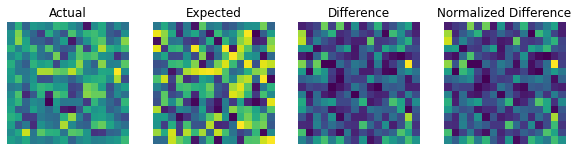

In [9]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

model.eval()
#image is a numpy array
inputs = torch.rand(1, 4, 16, 16)
outputs = model(inputs).detach().numpy()
labels = inputs[:, 0:3, :, :].detach().numpy()
# imshow(inputs[0, 0, :, :])
diff = outputs[0, 0, :, :] - labels[0, 0, :, :]
diff = np.sqrt(diff * diff)

fig = plt.figure(figsize=(10, 7))
rows = 1
cols = 4
# Adds a subplot at the 1st position
fig.add_subplot(rows, cols, 1)
  
# showing image
plt.imshow(outputs[0, 0, :, :])
plt.axis('off')
plt.title("Actual")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, cols, 2)
  
# showing image
plt.imshow(labels[0, 0, :, :])
plt.axis('off')
plt.title("Expected")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, cols, 3)
  
# showing image
plt.imshow(diff)
plt.axis('off')
plt.title("Difference")
print("Difference:", diff.sum() / diff.size)


fig.add_subplot(rows, cols, 4)

normalized = (np.sum(labels[0, 0, :, :])/np.sum(outputs[0, 0, :, :])) * outputs[0, 0, :, :]
diff = normalized - labels[0, 0, :, :]
diff = np.sqrt(diff * diff)
# showing image
plt.imshow(diff)
plt.axis('off')
plt.title("Normalized Difference")
print("Normalized Difference:", diff.sum() / diff.size)

## PhiFlow Things

In [83]:
def stackGrids(den, vel, xMax, yMax, bound = None):
    den = CenteredGrid(den, 0, Box[0:xMax, 0:yMax], x=xMax, y=yMax)
    vel = StaggeredGrid(vel, 0, Box[0:xMax, 0:yMax], x=xMax, y=yMax)
    
    den_val = den.values.numpy(["x","y"])
    vel_x = vel.at_centers().vector['x'].values.numpy(["x","y"])
    vel_y = vel.at_centers().vector['y'].values.numpy(["x","y"])
    if (bound is None):
        x = np.stack((den_val, vel_x, vel_y), axis=0)
    else:
        bound_val = bound.values.numpy(['x', 'y'])
        x = np.stack((den_val, vel_x, vel_y, bound_val), axis=0)
    return torch.tensor([x])

In [11]:
def simulateFlow(den, vel, GRAVITY, DT):
    den = advect.mac_cormack(den, vel, dt=DT)
    gravity_force = den * GRAVITY * DT @ vel
    vel = advect.semi_lagrangian(vel, vel, dt=DT) + gravity_force
    vel, _ = fluid.make_incompressible(vel)
    return den, vel

In [92]:
from phi.torch.flow import *
import phi.math as phim
import numpy as np

#1 epoch is a full simulation
def train_one_epoch(model, optimizer, loss_fn, input_num, num_frames, size=32):
    scene = Scene.at("./data/size" + str(size), input_num)
    
    bound = CenteredGrid(0, extrapolation.ONE, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
    bound = CenteredGrid(bound, x=size, y=size, bounds=Box[0:size, 0:size])
    
    loss_total = 0.0
    
    for frame in range(num_frames):
        den_input, vel_input = scene.read(['water', 'velocity'], frame=frame)
        X = stackGrids(den_input, vel_input, size, size, bound)
        optimizer.zero_grad()
        outputs = model(X)
        
        den_expect, vel_expect = scene.read(['water', 'velocity'], frame=frame+1)
        Y = stackGrids(den_expect, vel_expect, size, size)
        
        loss = loss_fn(outputs, Y)
        loss.backward()
        optimizer.step()
        
        loss_total += loss.item()
        
    # Gather data and report
    loss_average = loss_total / num_frames
    print('Sample number:', input_num, '| size:' ,size, "| batch loss:", loss_average)
        
    return loss_average

In [13]:
def validation(model, optimizer, loss_fn, input_num, num_frames, size=32):
    scene = Scene.at("./data/size" + str(size), input_num)
    
    bound = CenteredGrid(0, extrapolation.ONE, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
    bound = CenteredGrid(bound, x=size, y=size, bounds=Box[0:size, 0:size])
    
    loss_total = 0.0
    
    for frame in range(num_frames):
        den_input, vel_input = scene.read(['water', 'velocity'], frame=frame)
        X = stackGrids(den_input, vel_input, size, size, bound)
        outputs = model(X)
        
        den_expect, vel_expect = scene.read(['water', 'velocity'], frame=frame+1)
        Y = stackGrids(den_expect, vel_expect, size, size)
        
        loss = loss_fn(outputs, Y)
        loss_total += loss.item()

        
    # Gather data and report
    #print(size, "validation loss total:", loss_total)
        
    return loss_total / num_frames

In [14]:
def train(model, size, samples, num_frames, validation_split, epochs):
    epoch_hist = []
    
    last_loss = 100
    patience = 2
    triggertimes = 0
    for e in range(epochs):
        #train
        for i in range(samples - validation_split):
            train_one_epoch(model, optimizer, loss_fn, i, num_frames, size=size)
        
        
        #validation
        loss_total = 0.0
        for i in range(samples - validation_split, samples):
            loss_total += validation(model, optimizer, loss_fn, i, num_frames, size=size)
        current_loss = loss_total / (validation_split)
        print(e, 'epoch. The Current Loss:', current_loss)
        epoch_hist.append(current_loss)
        
        #early stopping
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model, epoch_hist

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss
    return model, epoch_hist

In [18]:
model = UNet(4, 3, 8)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [84]:
model.train()
size = 64
samples = 128
num_frames = 32
validation_split = 8
epochs = 100
model, epochs = train(model, size, samples, num_frames, validation_split, epochs)

Sample number: 0 | size: 64 | batch loss: 1.4427456222474575
Sample number: 1 | size: 64 | batch loss: 1.2231441708281636
Sample number: 2 | size: 64 | batch loss: 1.6175954546779394
Sample number: 3 | size: 64 | batch loss: 1.438515859656036
Sample number: 4 | size: 64 | batch loss: 1.5612155618146062
Sample number: 5 | size: 64 | batch loss: 1.5318424087017775
Sample number: 6 | size: 64 | batch loss: 1.1455882331356406
Sample number: 7 | size: 64 | batch loss: 1.363135150168091
Sample number: 8 | size: 64 | batch loss: 1.4161300640553236
Sample number: 9 | size: 64 | batch loss: 1.162837048061192
Sample number: 10 | size: 64 | batch loss: 1.3634974164888263
Sample number: 11 | size: 64 | batch loss: 1.666940486524254
Sample number: 12 | size: 64 | batch loss: 0.9654283737763762
Sample number: 13 | size: 64 | batch loss: 0.8816354055888951
Sample number: 14 | size: 64 | batch loss: 1.1946791913360357
Sample number: 15 | size: 64 | batch loss: 1.4958144607953727
Sample number: 16 | si

Sample number: 12 | size: 64 | batch loss: 0.7923564403317869
Sample number: 13 | size: 64 | batch loss: 0.7778691435232759
Sample number: 14 | size: 64 | batch loss: 0.8801879286766052
Sample number: 15 | size: 64 | batch loss: 1.0395082286559045
Sample number: 16 | size: 64 | batch loss: 1.2109125163406134
Sample number: 17 | size: 64 | batch loss: 1.115640624659136
Sample number: 18 | size: 64 | batch loss: 1.0066610556095839
Sample number: 19 | size: 64 | batch loss: 1.1106751766055822
Sample number: 20 | size: 64 | batch loss: 1.18751085922122
Sample number: 21 | size: 64 | batch loss: 1.02875403361395
Sample number: 22 | size: 64 | batch loss: 1.0000305408611894
Sample number: 23 | size: 64 | batch loss: 1.3931123479269445
Sample number: 24 | size: 64 | batch loss: 0.8149787201546133
Sample number: 25 | size: 64 | batch loss: 0.855248044943437
Sample number: 26 | size: 64 | batch loss: 0.8487164746038616
Sample number: 27 | size: 64 | batch loss: 1.058906747493893
Sample number: 

Sample number: 24 | size: 64 | batch loss: 0.7191771001089364
Sample number: 25 | size: 64 | batch loss: 0.7775404257699847
Sample number: 26 | size: 64 | batch loss: 0.7682447838597
Sample number: 27 | size: 64 | batch loss: 0.9476862312294543
Sample number: 28 | size: 64 | batch loss: 0.8334211860783398
Sample number: 29 | size: 64 | batch loss: 0.7216498628258705
Sample number: 30 | size: 64 | batch loss: 0.809039720101282
Sample number: 31 | size: 64 | batch loss: 1.014403698965907
Sample number: 32 | size: 64 | batch loss: 1.0343624502420425
Sample number: 33 | size: 64 | batch loss: 0.9288165492471308
Sample number: 34 | size: 64 | batch loss: 0.6627980964258313
Sample number: 35 | size: 64 | batch loss: 0.875767984194681
Sample number: 36 | size: 64 | batch loss: 0.6319812498986721
Sample number: 37 | size: 64 | batch loss: 1.0215477021411061
Sample number: 38 | size: 64 | batch loss: 0.8407195454929024
Sample number: 39 | size: 64 | batch loss: 0.7532350108958781
Sample number:

KeyboardInterrupt: 

In [ ]:
torch.save(model, './models/model_long')

In [ ]:
model = torch.load('models/model_long.pt')

# Evaluate model

In [121]:
size = 64
num_frames = 32

GRAVITY = math.tensor([0, -9.81])
DT = 1

den = CenteredGrid(Noise(), extrapolation.ZERO, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
den_ref = CenteredGrid(den, extrapolation.ZERO, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
vel = StaggeredGrid(0, extrapolation.ZERO, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
vel_ref = StaggeredGrid(vel, extrapolation.ZERO, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])

bound = CenteredGrid(0, extrapolation.ONE, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
bound = CenteredGrid(bound, x=size, y=size, bounds=Box[0:size, 0:size])

for i in range(num_frames):
    x = stackGrids(den, vel, size, size, bound)
    output = model(x)
    den_in = output[0,0]
    print(den_in)
    
#     den = CenteredGrid(output[0,0,:,:], extrapolation.ZERO, x=size-2, y=size-2, bounds=Box[1:size-1, 1:size-1])
    
#     den_ref, vel_ref = simulateFlow(den_ref, vel_ref, GRAVITY, DT)
#     output_ref = stackGrids(den_ref, vel_ref, size, size)
    
#     diff = output_ref - output

tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0138],
        [-0.1453,  0.9936,  0.6423,  ...,  0.2676,  0.1381, -0.0325],
        [-0.0965,  1.0500,  0.6325,  ...,  0.2401,  0.1764, -0.0251],
        ...,
        [ 0.0645,  0.8981,  0.3629,  ...,  0.3716,  0.2609, -0.0399],
        [-0.0650,  1.3185,  0.6650,  ...,  0.4106,  0.2829,  0.0221],
        [-0.0369,  0.5498, -0.0681,  ..., -0.1093, -0.1265, -0.1432]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0138],
        [-0.1453,  0.9936,  0.6423,  ...,  0.2676,  0.1381, -0.0325],
        [-0.0965,  1.0500,  0.6325,  ...,  0.2401,  0.1764, -0.0251],
        ...,
        [ 0.0645,  0.8981,  0.3629,  ...,  0.3716,  0.2609, -0.0399],
        [-0.0650,  1.3185,  0.6650,  ...,  0.4106,  0.2829,  0.0221],
        [-0.0369,  0.5498, -0.0681,  ..., -0.1093, -0.1265, -0.1432]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0

tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0138],
        [-0.1453,  0.9936,  0.6423,  ...,  0.2676,  0.1381, -0.0325],
        [-0.0965,  1.0500,  0.6325,  ...,  0.2401,  0.1764, -0.0251],
        ...,
        [ 0.0645,  0.8981,  0.3629,  ...,  0.3716,  0.2609, -0.0399],
        [-0.0650,  1.3185,  0.6650,  ...,  0.4106,  0.2829,  0.0221],
        [-0.0369,  0.5498, -0.0681,  ..., -0.1093, -0.1265, -0.1432]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0138],
        [-0.1453,  0.9936,  0.6423,  ...,  0.2676,  0.1381, -0.0325],
        [-0.0965,  1.0500,  0.6325,  ...,  0.2401,  0.1764, -0.0251],
        ...,
        [ 0.0645,  0.8981,  0.3629,  ...,  0.3716,  0.2609, -0.0399],
        [-0.0650,  1.3185,  0.6650,  ...,  0.4106,  0.2829,  0.0221],
        [-0.0369,  0.5498, -0.0681,  ..., -0.1093, -0.1265, -0.1432]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0806,  0.1657,  0.1181,  ...,  0.0656, -0.0229,  0.0

In [15]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def test_model(model, size=32, num_frames=1):
    GRAVITY = math.tensor([0, -9.81])
    DT = 1
    xMax = size
    yMax = size
    boundsBox=Box[0:xMax, 0:yMax]
    activeBoundsBox=Box[1:xMax-1, 1:yMax-1]

    den_ref = CenteredGrid(Noise(), extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    vel_ref = StaggeredGrid(0, extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)

    bound = CenteredGrid(0, extrapolation.ONE, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
    bound = CenteredGrid(bound, x=xMax, y=yMax, bounds=boundsBox)

    den = den_ref
    vel = vel_ref
    
    vel += den * GRAVITY * DT @ vel
    vel, _ = fluid.make_incompressible(vel)
    
    for i in range(num_frames):
        # Create a 2 x 4 plot for the values
        fig = plt.figure(figsize=(10, 7))
        rows = 3
        cols = 4
        
        # Plot Input Density, Velocities, and Barrier
        
        x = stackGrids(den, vel, xMax, yMax, bound)
        den_val = den.values.numpy(["x","y"])
        den_min = den_val.min()
        den_max = den_val.max()
        den_sum = (den_val+den_min).sum()
        print("Density Min", den_min)
        print("Density Max", den_max)
        print("Density Sum", den_sum)
        
        fig.add_subplot(rows, cols, 1)
        plt.imshow(x[0, 0, :, :])
        plt.axis('off')
        plt.title("Input Density")
        
        fig.add_subplot(rows, cols, 2)
        plt.imshow(x[0, 1, :, :])
        plt.axis('off')
        plt.title("Input Vel X")
        
        fig.add_subplot(rows, cols, 3)
        plt.imshow(x[0, 2, :, :])
        plt.axis('off')
        plt.title("Input Vel Y")
        
        fig.add_subplot(rows, cols, 4)
        plt.imshow(x[0, 3, :, :])
        plt.axis('off')
        plt.title("Input Barriers")
        
        # Plot PhiFlow's Output
        
        den, vel = simulateFlow(den, vel, GRAVITY, DT) 
        y = stackGrids(den, vel, xMax, yMax)
        
        fig.add_subplot(rows, cols, 5)
        plt.imshow(y[0, 0, :, :])
        plt.axis('off')
        plt.title("Expected Density")
        
        fig.add_subplot(rows, cols, 6)
        plt.imshow(y[0, 1, :, :])
        plt.axis('off')
        plt.title("Expected Vel X")
        
        fig.add_subplot(rows, cols, 7)
        plt.imshow(y[0, 2, :, :])
        plt.axis('off')
        plt.title("Expected Vel Y")
        
        # Plot Model's Output
        
        outputs = model(x).detach().numpy()
        
        fig.add_subplot(rows, cols, 9)
        plt.imshow(outputs[0, 0, :, :])
        plt.axis('off')
        plt.title("Model's Density")
        
        fig.add_subplot(rows, cols, 10)
        plt.imshow(outputs[0, 1, :, :])
        plt.axis('off')
        plt.title("Model's Vel X")
        fig.add_subplot(rows, cols, 11)
        plt.imshow(outputs[0, 2, :, :])
        plt.axis('off')
        plt.title("Model's Vel Y")

Density Min -3.0576708
Density Max 2.4074595
Density Sum -11753.6875
Density Min -3.0576708
Density Max 2.4074595
Density Sum -11936.839
Density Min -3.009289
Density Max 2.4074595
Density Sum -11747.441
Density Min -3.009289
Density Max 2.4074595
Density Sum -11728.653


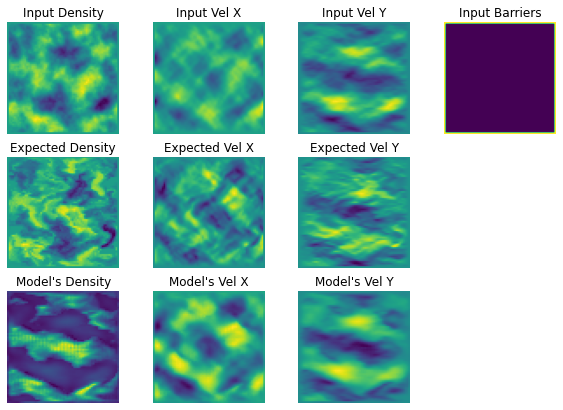

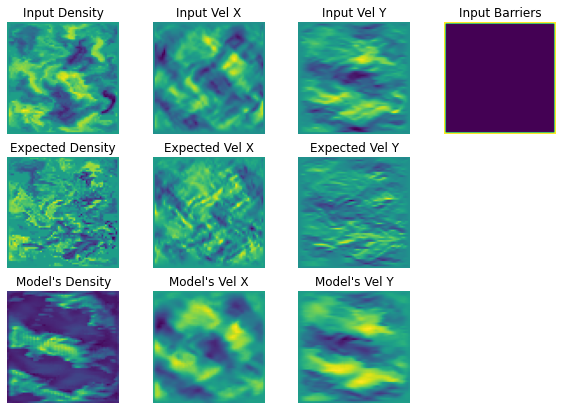

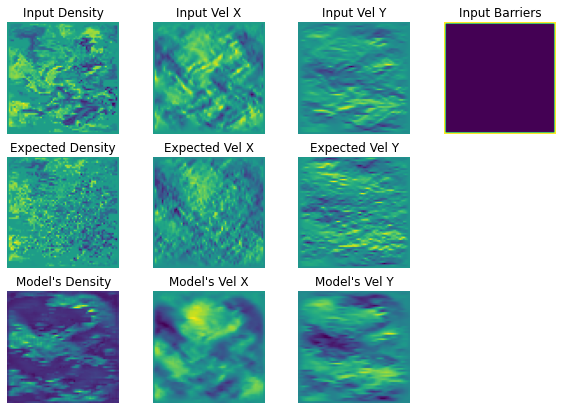

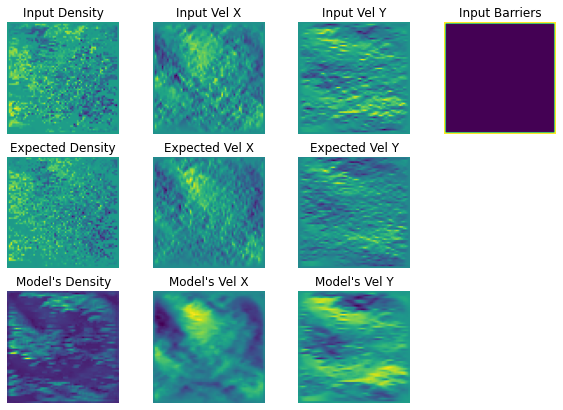

In [16]:
model.eval()
test_model(model, 64, 4)

## Attempting to Animate

TO DO

In [434]:
import numpy as np  
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter  
%matplotlib inline

In [474]:
def clean_output(X, in_den_sum, boundary):
    out_den = X[0,0]
    # out_den = out_den - out_den.min()
    out_den[boundary==1] = 0
    # out_den_sum = out_den.sum()
    # return (in_den_sum/out_den_sum) * out_den
    return out_den

In [1]:
size = 64
GRAVITY = math.tensor([0, -9.81])
DT = 1
xMax = size
yMax = size
boundsBox=Box[0:xMax, 0:yMax]
activeBoundsBox=Box[1:xMax-1, 1:yMax-1]

den_ref = CenteredGrid(Noise(), extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
vel_ref = StaggeredGrid(0, extrapolation.ZERO, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)

bound = CenteredGrid(0, extrapolation.ONE, x=xMax-2, y=yMax-2, bounds=activeBoundsBox)
bound = CenteredGrid(bound, x=xMax, y=yMax, bounds=boundsBox)

den = den_ref
vel = vel_ref

vel += den * GRAVITY * DT @ vel
vel, _ = fluid.make_incompressible(vel)

x = stackGrids(den, vel, xMax, yMax, bound)
den, vel = simulateFlow(den, vel, GRAVITY, DT) 
y = stackGrids(den, vel, xMax, yMax)

bound_val = bound.values.numpy(['x', 'y'])

den_sum = np.sum(den_ref.values.numpy(["x","y"]))

def update():
    global x
    y = model(x).detach().numpy()
    x = torch.tensor(np.expand_dims(np.stack((y[0, 0], y[0, 1], (y[0, 2]), bound_val), axis=0), 0))
    x[0,0] = clean_output(x, den_sum, bound_val)
    return y

NameError: name 'math' is not defined

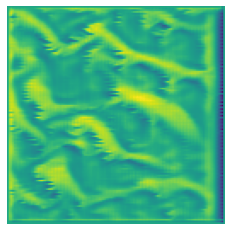

In [476]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.animation as animation 

fig = plt.figure() 

ims = []
for i in range(10):
    plt.axis('off')
    im = plt.imshow(update()[0][0])
    ims.append([im])

In [477]:
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
ani.save('water_sim_128_1.mp4')